In [6]:
import pandas as pd
import numpy as np

# not skipping empty values, to demonstrate data preprocessing steps later
df = pd.read_csv('datasets/model_car_sales.csv', na_filter=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 8 columns):
LOCATION_NUMBER    675 non-null int64
REPORT_DATE        675 non-null object
DEALER_CODE        675 non-null object
UTE                675 non-null object
HATCH              675 non-null object
WAG0N              675 non-null object
SEDAN              675 non-null object
K__SALES_TOT       675 non-null object
dtypes: int64(1), object(7)
memory usage: 42.3+ KB


In [17]:
# get more information from Wagon
print(df['WAG0N'].describe())
print(df['WAG0N'].value_counts())

count     653.000000
mean      446.993874
std       212.044763
min         2.000000
25%       313.000000
50%       430.000000
75%       574.000000
max      1224.000000
Name: WAG0N, dtype: float64
382.0     5
442.0     5
422.0     4
339.0     4
410.0     4
447.0     4
325.0     4
451.0     4
313.0     4
446.0     4
254.0     4
444.0     4
6.0       4
319.0     4
351.0     4
8.0       4
369.0     3
485.0     3
439.0     3
294.0     3
391.0     3
284.0     3
274.0     3
307.0     3
457.0     3
333.0     3
589.0     3
409.0     3
288.0     3
372.0     3
         ..
898.0     1
301.0     1
659.0     1
330.0     1
287.0     1
390.0     1
290.0     1
636.0     1
652.0     1
495.0     1
764.0     1
349.0     1
481.0     1
494.0     1
1127.0    1
207.0     1
302.0     1
877.0     1
429.0     1
1224.0    1
684.0     1
314.0     1
637.0     1
486.0     1
716.0     1
266.0     1
361.0     1
253.0     1
1110.0    1
1132.0    1
Name: WAG0N, Length: 425, dtype: int64


In [8]:
# replace the empty strings in the series with nan and typecast to float
df['UTE'] = df['UTE'].replace('', np.nan).astype(float)
df['HATCH'] = df['HATCH'].replace('', np.nan).astype(float)
df['WAG0N'] = df['WAG0N'].replace('', np.nan).astype(float)
df['SEDAN'] = df['SEDAN'].replace('', np.nan).astype(float)

df['K__SALES_TOT'] = df['K__SALES_TOT'].replace('', np.nan).astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 8 columns):
LOCATION_NUMBER    675 non-null int64
REPORT_DATE        675 non-null object
DEALER_CODE        675 non-null object
UTE                653 non-null float64
HATCH              653 non-null float64
WAG0N              653 non-null float64
SEDAN              653 non-null float64
K__SALES_TOT       653 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 42.3+ KB


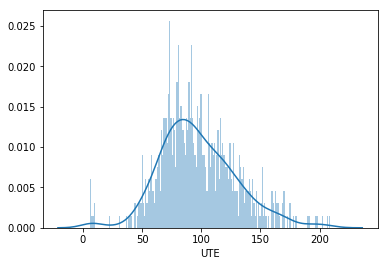

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


medhhinc_dist = sns.distplot(df['UTE'].dropna(), bins=200)
plt.show()


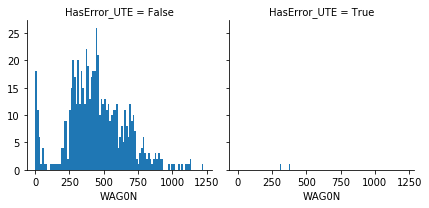

In [38]:
# create a mask of errorneous MeanHHSz values
df['HasError_UTE'] = df['UTE'] < 30

# use FaceTGrid to plot the distribution of MedHHInc when MeanHHSZ is errorneous
g = sns.FacetGrid(df, col='HasError_UTE')
g = g.map(plt.hist, 'WAG0N', bins=100)

plt.show()

Couldn't really find any similarities between outliers in the different features.

In [42]:
# Finding what car model is underperforming in sales.
print("Sum of sales for UTE:", df['UTE'].sum())
print("Sum of sales for HATCH:", df['HATCH'].sum())
print("Sum of sales for WAG0N:", df['WAG0N'].sum())
print("Sum of sales for SEDAN:", df['SEDAN'].sum())

Sum of sales for UTE: 63461.0
Sum of sales for HATCH: 1249893.0
Sum of sales for WAG0N: 291887.0
Sum of sales for SEDAN: 1208610.0


This shows that the UTE is by far the most underperforming car model by sales numbers.

<h2>Bulding the K-means cluster</h2> 

In [69]:
from  sklearn.preprocessing  import StandardScaler

# Only continue with the selected features.
df_selection = df[['HATCH', 'WAG0N', 'SEDAN']]

# Removes all null values.
df_selection = df_selection[df_selection['HATCH'] >= 1]
df_selection = df_selection[df_selection['WAG0N'] >= 1]
df_selection = df_selection[df_selection['SEDAN'] >= 1]

df_selection.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 674
Data columns (total 3 columns):
HATCH    653 non-null float64
WAG0N    653 non-null float64
SEDAN    653 non-null float64
dtypes: float64(3)
memory usage: 20.4 KB


In [57]:
from sklearn.cluster import KMeans

# convert the featured selection to matrix
X = df_selection.as_matrix()

# random state, set to 10 for continuity from previous Case Study
rs = 10
k = 3

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=k, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 75703830.81117672
Centroid locations:
[2.22190244e+03 4.12118467e+02 1.67159930e+03 1.67247387e+00]
[1.69644937e+03 5.36813291e+02 2.06781646e+03 4.49367089e-01]
[1.52258e+03 7.95200e+01 1.50862e+03 1.12000e+00]


Distribution for Cluster ID:s
1    316
0    287
2     50
Name: Cluster_ID, dtype: int64


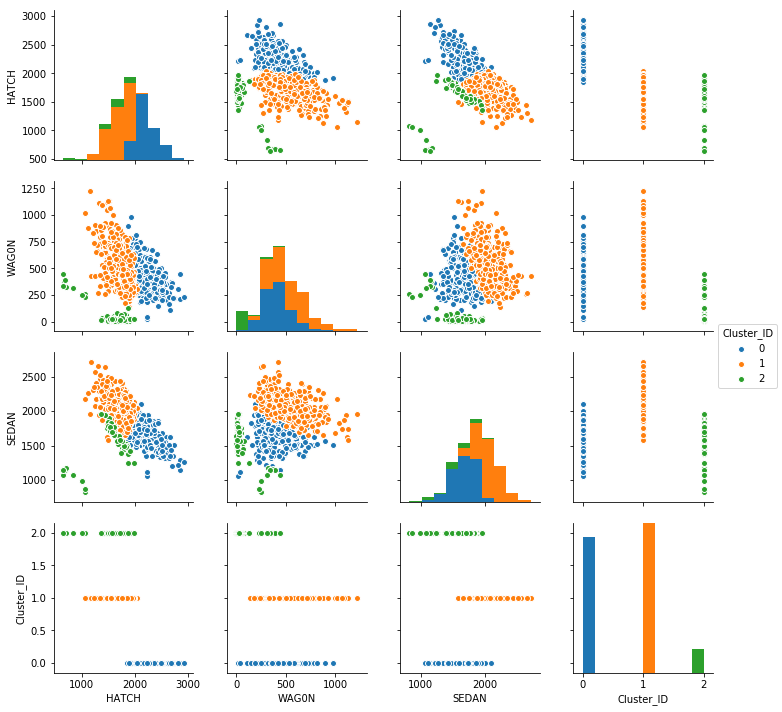

In [58]:
# assign cluster ID to each record in X
df_selection['Cluster_ID'] = model.predict(X)

# how many records are in each cluster
print("Distribution for Cluster ID:s")
print(df_selection['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df_selection, hue='Cluster_ID')
plt.show()

In [70]:
# convert the featured selection to matrix
X = df_selection.as_matrix()

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

Remember, in clustering, we want to minimize the intra-cluster distance while maximizing the inter-cluster distances. After the model is fitted, print out its inertia (sum of distances of samples to their closest cluster center/centroid) and centroid locations.

In [71]:
from sklearn.cluster import KMeans

# random state, set to 10 for continuity from previous Case Study
rs = 10
k = 3

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=k, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 954.6325835439618
Centroid locations:
[-0.34970182 -0.45260326  0.7935408 ]
[-0.84831714  1.22340055  0.1881452 ]
[ 0.86563189 -0.38489507 -0.83804699]


Distribution for Cluster ID:s
2    256
0    231
1    166
Name: Cluster_ID, dtype: int64


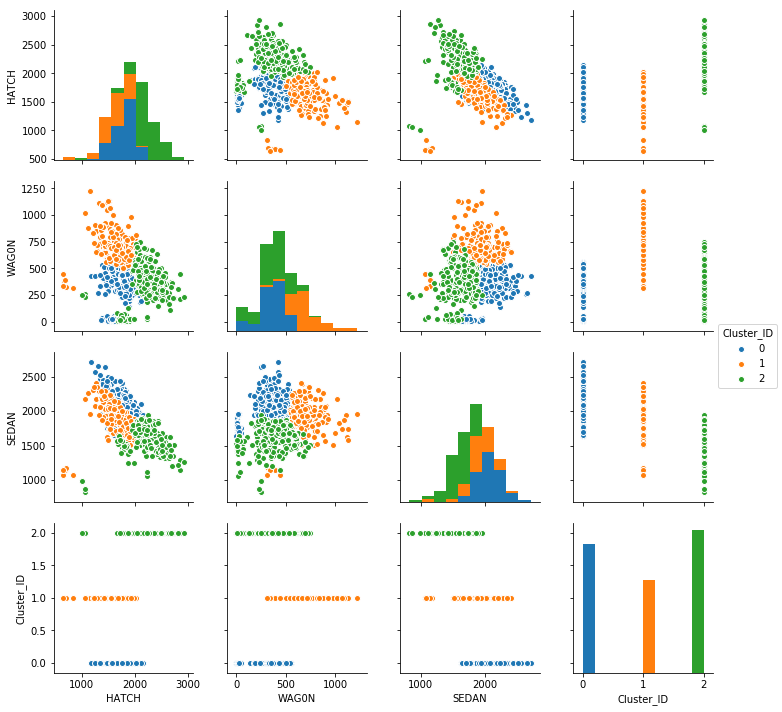

In [72]:
# assign cluster ID to each record in X
df_selection['Cluster_ID'] = model.predict(X)

# how many records are in each cluster
print("Distribution for Cluster ID:s")
print(df_selection['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df_selection, hue='Cluster_ID')
plt.show()

In [75]:
# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 15):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

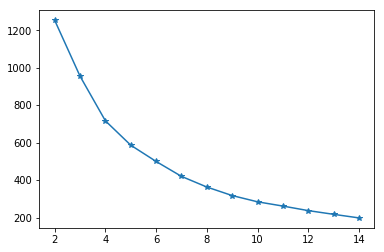

In [76]:
# plot the inertia vs K values
plt.plot(range(2,15), inertia_vals, marker='*')
plt.show()

In [79]:

from  sklearn.metrics import silhouette_score

print("Silhouette score for k=3", silhouette_score(X, clusters[1].predict(X)))
print("Silhouette score for k=4", silhouette_score(X, clusters[2].predict(X)))
print("Silhouette score for k=5", silhouette_score(X, clusters[3].predict(X)))
print("Silhouette score for k=6", silhouette_score(X, clusters[4].predict(X)))
print("Silhouette score for k=7", silhouette_score(X, clusters[5].predict(X)))
print("Silhouette score for k=8", silhouette_score(X, clusters[6].predict(X)))

Silhouette score for k=3 0.3265376976323032
Silhouette score for k=4 0.3708685914944794
Silhouette score for k=5 0.33883563551841106
Silhouette score for k=6 0.3577177137614231
Silhouette score for k=7 0.3501785416602084
Silhouette score for k=8 0.3447008541468837


In [80]:
from sklearn.cluster import KMeans

# random state, set to 10 for continuity from previous Case Study
rs = 10
k = 4 # Best number according to Silhouette score

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=k, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 716.230881930561
Centroid locations:
[ 0.99997728 -0.1938563  -0.73224141]
[-0.80093587  1.35749593  0.30525401]
[-1.03516567 -1.74277435 -1.23655208]
[-0.29195186 -0.28188141  0.87186524]


Distribution for Cluster ID:s
0    235
3    220
1    146
2     52
Name: Cluster_ID, dtype: int64


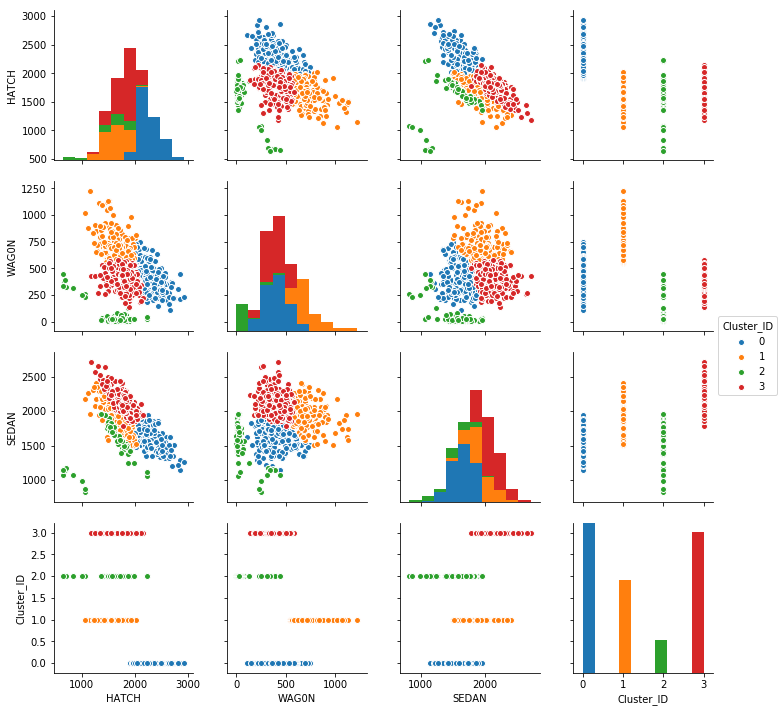

In [81]:
# assign cluster ID to each record in X
df_selection['Cluster_ID'] = model.predict(X)

# how many records are in each cluster
print("Distribution for Cluster ID:s")
print(df_selection['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df_selection, hue='Cluster_ID')
plt.show()